# Impact Detection

In [1]:
# imports
import os
import json
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

## Load Pose Estimates

https://cmu-perceptual-computing-lab.github.io/openpose/web/html/doc/md_doc_02_output.html

In [2]:
# function to interpolate missing pose estimates
# https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array
def interpolate_pose_estimates(a):
    found = a != 0
    not_found = a == 0
    xp = found.nonzero()[0]
    fp = a[found]
    x  = not_found.nonzero()[0]

    a[not_found] = np.interp(x, xp, fp)
    return a

# function to load pose estimates
def load_pose_estimates(load_dir, vid_name, fps):
    json_files = sorted(os.listdir(os.path.join(load_dir, vid_name)))
    json_paths = [(int(json_file.split('_')[1]), os.path.join(load_dir, vid_name, json_file)) for json_file in json_files if '.json' in json_file]
    n_frames = len(json_paths)
    
    pose_x = np.empty((n_frames, 18))
    pose_y = np.empty((n_frames, 18))
    pose_c = np.empty((n_frames, 18))
    time_stamps = np.empty((n_frames))
    for frm, json_path in json_paths: 
        with open(json_path, 'r') as f:
            json_dict = json.load(f)
        x = json_dict['people'][0]['pose_keypoints_2d'][0::3]
        y = json_dict['people'][0]['pose_keypoints_2d'][1::3]
        c = json_dict['people'][0]['pose_keypoints_2d'][2::3]
        pose_x[frm] = x
        pose_y[frm] = y
        pose_c[frm] = c
        time_stamps[frm] = frm/fps
        
    # interpolate missing pose estimates
    for limb in range(18):
        pose_x[:,limb] = interpolate_pose_estimates(pose_x[:,limb])
        pose_y[:,limb] = interpolate_pose_estimates(pose_y[:,limb])
        
    print(f'Interpolation correct? {(pose_x != 0).all() and (pose_y != 0).all()}')
        
    return pose_x, pose_y, pose_c, time_stamps

# load pose estimates for j1
load_dir = os.path.join('..', 'data', 'output_jsons')
vid_name = 'j2'
fps = 60

pose_x, pose_y, pose_c, time_stamps = load_pose_estimates(load_dir, vid_name, fps)
pose_x.shape, pose_y.shape, pose_c.shape, time_stamps.shape

Interpolation correct? True


((3192, 18), (3192, 18), (3192, 18), (3192,))

## Detect Impact Points

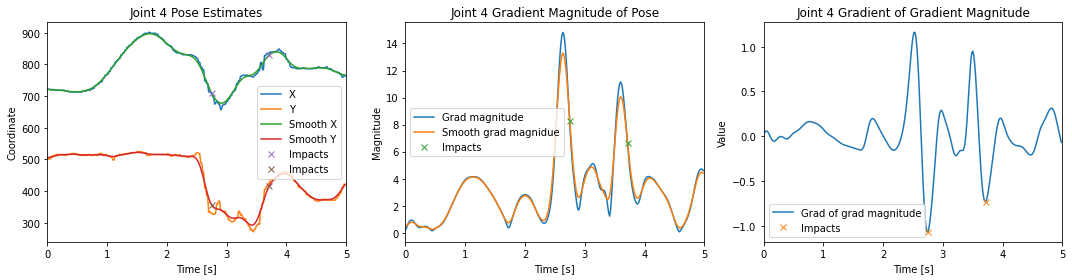

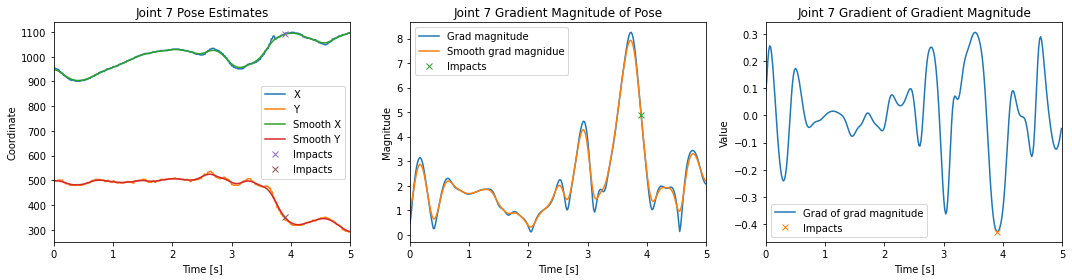

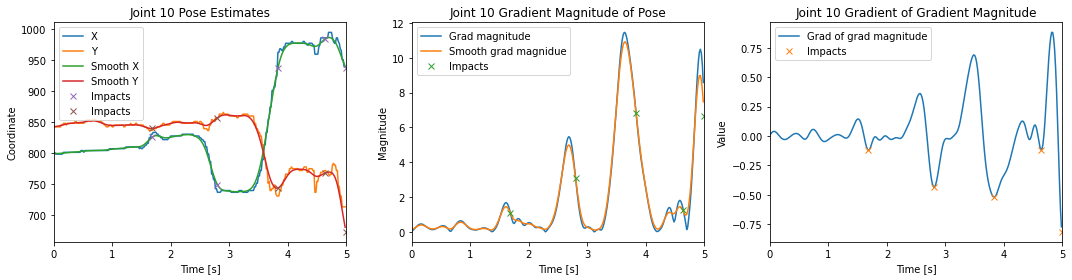

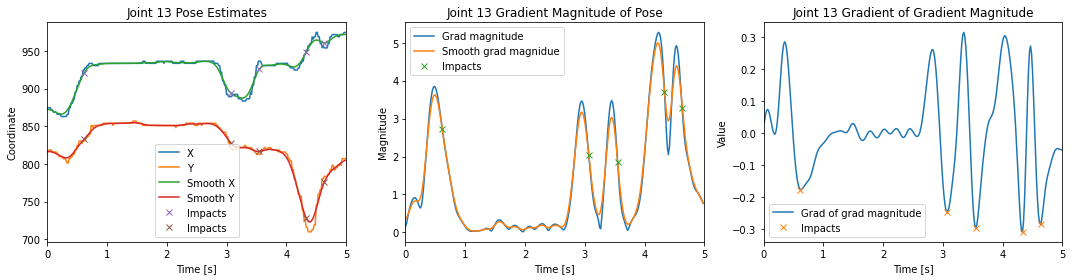

Percentage impacts per limb: [2.2556391  1.94235589 2.38095238 2.19298246]


In [3]:
# function to detect impact points
def detect_impact_points(pose_x, pose_y, pose_c, time_stamps, limb_indices, gm_thresh=[3, 3, 1, 1], ggm_thresh=[-0.4, -0.4, -0.1, -0.1], fps=60, fig_dir=None):
    assert len(pose_x) == len(pose_y) and len(pose_x) == len(pose_c) and len(pose_x) == len(time_stamps)
    
    # detect impact points for each limb
    n_frames = len(time_stamps)
    n_limbs = len(limb_indices)
    impact_points = np.zeros((n_frames, n_limbs), dtype=bool)
    for i, limb in enumerate(limb_indices):
        x = pose_x[:,limb]
        y = pose_y[:,limb]
        c = pose_c[:,limb] # just a confidence value, probably not necessary
        
        # parameters
        sigma_0 = 5
        sigma_1 = 3
        peak_distance = 10
        
        # smooth coordinates
        x_filt = gaussian_filter1d(x, sigma_0)
        y_filt = gaussian_filter1d(y, sigma_0)
        
        # gradients
        x_grad = np.gradient(x_filt)
        y_grad = np.gradient(y_filt)
        grad_mag = np.sqrt(x_grad**2 + y_grad**2)
        grad_mag_filt = gaussian_filter1d(grad_mag, sigma_1)
        grad_grad_mag = np.gradient(grad_mag_filt)
        
        # impact detection: troughs in ggm that exceed gm threshold
        impacts_idx, _ = find_peaks(-grad_grad_mag, height=-ggm_thresh[i], distance=peak_distance)
        impacts_idx = impacts_idx[grad_mag_filt[impacts_idx] >= gm_thresh[i]]
        
        limb_impacts = np.zeros((n_frames), dtype=bool)
        limb_impacts[impacts_idx] = True
        impact_points[:,i] = limb_impacts
        
        # plot
        if fig_dir:
            start_second = 0
            num_seconds = 5
            start_i = int(fps * start_second)
            end_i = int(start_i + fps * num_seconds)
            
            t = np.arange(start_i, end_i) / fps
            impacts_plot = impacts_idx[np.logical_and(impacts_idx >= start_i, impacts_idx <= end_i)]
            fig = plt.figure(figsize=(15, 4), facecolor='w')
            
            plt.subplot(1, 3, 1)
            plt.plot(t, x[start_i:end_i], label='X')
            plt.plot(t, y[start_i:end_i], label='Y')
            plt.plot(t, x_filt[start_i:end_i], label='Smooth X')
            plt.plot(t, y_filt[start_i:end_i], label='Smooth Y')
            plt.plot(impacts_plot / fps, x_filt[impacts_plot], 'x', label='Impacts')
            plt.plot(impacts_plot / fps, y_filt[impacts_plot], 'x', label='Impacts')
            plt.title(f'Joint {limb} Pose Estimates')
            plt.xlabel('Time [s]')
            plt.ylabel('Coordinate')
            plt.xlim(start_second, start_second + num_seconds)
            plt.legend()

            plt.subplot(1, 3, 2)
            plt.plot(t, grad_mag[start_i:end_i], label='Grad magnitude')
            plt.plot(t, grad_mag_filt[start_i:end_i], label='Smooth grad magnidue')          
            plt.plot(impacts_plot / fps, grad_mag_filt[impacts_plot], 'x', label='Impacts')
            plt.title(f'Joint {limb} Gradient Magnitude of Pose')
            plt.xlabel('Time [s]')
            plt.ylabel('Magnitude')
            plt.xlim(start_second, start_second + num_seconds)
            plt.legend()

            plt.subplot(1, 3, 3)
            plt.plot(t, grad_grad_mag[start_i:end_i], label='Grad of grad magnitude')            
            plt.plot(impacts_plot / fps, grad_grad_mag[impacts_plot], 'x', label='Impacts')
            plt.title(f'Joint {limb} Gradient of Gradient Magnitude')
            plt.xlabel('Time [s]')
            plt.ylabel('Value')
            plt.xlim(start_second, start_second + num_seconds)
            plt.legend()
            plt.tight_layout()
            plt.show()
            fig.savefig(os.path.join(fig_dir, f'joint_{limb}_impacts.png'))
    
    assert len(impact_points) == len(time_stamps)
    return impact_points, time_stamps

# testing
fig_dir = os.path.join('..', 'figures', vid_name)
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
limb_indices = [4, 7, 10, 13] # hands and feet indices in COCO format
gm_thresh = [3, 3, 1, 1]
ggm_thresh = [-0.4, -0.4, -0.1, -0.1]
impact_points, time_stamps = detect_impact_points(pose_x, pose_y, pose_c, time_stamps, limb_indices, gm_thresh=gm_thresh, ggm_thresh=ggm_thresh, fps=fps, fig_dir=fig_dir)
print(f'Percentage impacts per limb: {100 * impact_points.mean(axis=0)}')

# save results to file
save_dir = os.path.join('..', 'data', 'impact_points')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

np.save(os.path.join(save_dir, f'{vid_name}_impact_points.npy'), impact_points)
np.save(os.path.join(save_dir, f'{vid_name}_time_stamps.npy'), time_stamps)

## Run on All Videos

In [4]:
# run impact detection for all videos
load_dir = os.path.join('..', 'data', 'output_jsons')
vid_info_df = pd.read_csv(os.path.join('..', 'video', 'video_info.csv'), index_col='vid_name')
limb_indices = [4, 7, 10, 13] # hands and feet indices in COCO format
pose_fps = 60

save_dir = os.path.join('..', 'data', 'impact_points')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# iterate over all videos
for vid_name in vid_info_df.index:
    if vid_name != 'group':
        print(10 * '-')
        print(vid_name)
        
        # load pose estimates
        pose_x, pose_y, pose_c, time_stamps = load_pose_estimates(load_dir, vid_name, pose_fps)
        
        # detect and save impact points and timestamps
        impact_points, time_stamps = detect_impact_points(pose_x, pose_y, pose_c, time_stamps, limb_indices, fps=fps)
        np.save(os.path.join(save_dir, f'{vid_name}_impact_points.npy'), impact_points)
        np.save(os.path.join(save_dir, f'{vid_name}_time_stamps.npy'), time_stamps)

----------
a1
Interpolation correct? True
----------
a2
Interpolation correct? True
----------
e1
Interpolation correct? True
----------
e2
Interpolation correct? True
----------
e3
Interpolation correct? True
----------
j1
Interpolation correct? True
----------
j2
Interpolation correct? True
----------
u1
Interpolation correct? True
----------
u2
Interpolation correct? True
